In [24]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append('../..')
import torch

In [25]:
from utils import train_from_dataset, MeasurementDataset, make_exp_schedule
from utils import train_from_filepath
from qtools import pauli_exp
from models import MPS

In [26]:
trlosses = np.load("data/trlosses.npy")
vallosses = np.load("data/vallosses.npy")
params = np.load("data/validated_params.npy").item()
with open("data/metadata.json") as f:
    metadata=json.load(f)

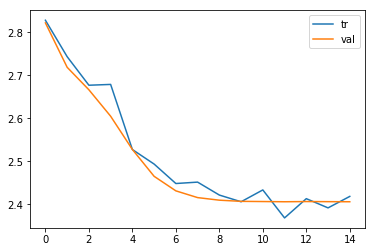

In [27]:
fig, ax = plt.subplots()
plt.plot(trlosses, label="tr")
plt.plot(vallosses, label="val")
plt.legend()

In [28]:
L=4
fname_settings = "../../datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "../../datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
fname_state = "../../datasets/mps_sampled/ghz_plus_L=%d_state"%L
output_dir = "./data"
Nsamp=20000


In [29]:
from models import MPS

In [30]:
lr_scale = params['lr_scale']
lr_timescale = params['lr_timescale']
s2_scale = params['s2_scale']
s2_timescale = params['s2_timescale']


In [31]:
params

{'lr_scale': 0.011654002405207753,
 'lr_timescale': 90.58898977882967,
 's2_scale': 3.1079530579214067e-06,
 's2_timescale': 76.10777229920316}

In [40]:
epochs = int(1.0*len(trlosses))
batch_size = metadata['batch_size']
cutoff=metadata['cutoff']
max_sv = metadata['max_sv']

In [41]:
model, logdict, meta = train_from_filepath(fname_samples, fname_settings,
                                           lr_scale, lr_timescale, s2_scale, s2_timescale,
                                           ground_truth_mps_path=fname_state,
                                           N=Nsamp,
                                           epochs=epochs,max_sv=max_sv,
                                           numpy_seed=0,
                                           cutoff=cutoff, batch_size=batch_size,
                                       use_cache=True, record_eigs=False,record_s2=True,verbose=True,
                                       compute_overlaps=True)

Successfully loaded 20000 settings, samples for system of size L=4
loading ground truth MPS from  ../../datasets/mps_sampled/ghz_plus_L=4_state
Training on system size 4 with 20000 samples


../../utils.py:825: UserWarning: overlap estimate failed to converge within tolerance 1.00e-02
  warnings.warn("overlap estimate failed to converge within tolerance {0:.2e}".format(eps))


Finished epoch 0 in 1.578 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 1 in 0.997 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 2 in 0.914 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 3 in 1.016 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 4 in 0.727 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 5 in 1.558 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 6 in 1.429 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 7 in 0.810 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 8 in 0.917 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 9 in 0.837 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 10 in 1.578 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 11 in 1.266 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 1)]
Finished epoch 12 in 0.808 sec
Model shape:  [(1, 2), (2, 4), (4, 2), (2, 

In [42]:
fidelity_mps = logdict['fidelity_mps']
fidelity_qutip = logdict['fidelity_qutip']
loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
eigs = logdict['eigenvalues']
s2 = logdict['s2']
val_loss = logdict['val_loss']
overlap = logdict['overlap']

Text(0.5,1,'batch NLL loss')

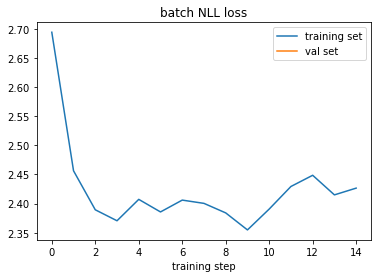

In [43]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='training set')
plt.plot(val_loss, label='val set')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss")


Text(0.5,1,'Overlap during training')

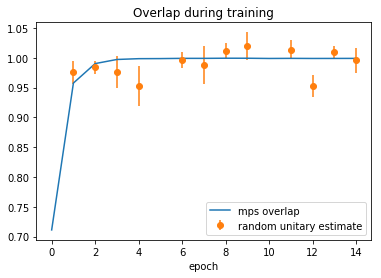

In [44]:
fig, ax = plt.subplots()
plt.plot(range(epochs), fidelity_mps**2, label='mps overlap')

c = overlap['converged']
plt.errorbar(np.arange(epochs)[c], overlap['mean'][c], yerr=overlap['err'][c], marker='o', linestyle='none', 
            label="random unitary estimate")
plt.legend()
plt.xlabel('epoch')
plt.title("Overlap during training")